In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

from tqdm import tqdm

from torchmetrics.classification import MulticlassF1Score, MulticlassAccuracy, ConfusionMatrix

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

In [3]:
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [4]:
train_dataset, val_dataset = random_split(train_dataset, [50000, 10000])

In [5]:
train = DataLoader(train_dataset, batch_size=64, shuffle=True)
val = DataLoader(val_dataset, batch_size= 1000, shuffle=True)
test = DataLoader(test_dataset, batch_size= 1000, shuffle=True)

In [42]:
class MNISTClassification(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 10, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(10, 20, kernel_size=5),
            nn.Dropout2d(),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.fc_block = nn.Sequential(
            nn.Linear(320, 50),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(50, 10)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = x.view(x.size(0), -1)
        x = self.fc_block(x)
        return F.log_softmax(x, dim=1)

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNISTClassification().to(device=device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

In [44]:
for epoch in range(10) :
    model.train()
    train_loss = 0

    loop = tqdm(train, desc=f"Epoch {epoch+1}/{10} [Training]", leave=False)
    for images, labels in loop :
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        output = model(images)
        loss = loss_fn(output, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        loop.set_postfix(loss=loss.item())

    model.eval()
    val_loss = 0
    f1 = MulticlassF1Score(num_classes=10, average='macro').to(device)
    accuracy = MulticlassAccuracy(num_classes=10, average='macro').to(device)

    with torch.no_grad() :
        val_loop = tqdm(val, desc=f"Epoch {epoch+1}/{10} [Validation]", leave=False)
        for images, labels in val_loop :
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            val_loop.set_postfix(loss=loss.item())

            f1.update(preds, labels)
            accuracy.update(preds, labels)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss/len(train):.4f} | "
          f"Val Loss: {val_loss/len(val):.4f} | Val F1: {f1.compute():.4f} | Val Acc: {accuracy.compute():.4f}")
    



Epoch 1 | Train Loss: 0.6291 | Val Loss: 0.1312 | Val F1: 0.9585 | Val Acc: 0.9587


Epoch 2 | Train Loss: 0.2794 | Val Loss: 0.0946 | Val F1: 0.9684 | Val Acc: 0.9684


Epoch 3 | Train Loss: 0.2288 | Val Loss: 0.0744 | Val F1: 0.9760 | Val Acc: 0.9760


Epoch 4 | Train Loss: 0.2007 | Val Loss: 0.0681 | Val F1: 0.9780 | Val Acc: 0.9781


Epoch 5 | Train Loss: 0.1846 | Val Loss: 0.0656 | Val F1: 0.9793 | Val Acc: 0.9793


Epoch 6 | Train Loss: 0.1729 | Val Loss: 0.0604 | Val F1: 0.9805 | Val Acc: 0.9805


Epoch 7 | Train Loss: 0.1719 | Val Loss: 0.0559 | Val F1: 0.9827 | Val Acc: 0.9827


Epoch 8 | Train Loss: 0.1581 | Val Loss: 0.0546 | Val F1: 0.9825 | Val Acc: 0.9824


Epoch 9 | Train Loss: 0.1531 | Val Loss: 0.0579 | Val F1: 0.9819 | Val Acc: 0.9821


Epoch 10 | Train Loss: 0.1469 | Val Loss: 0.0496 | Val F1: 0.9851 | Val Acc: 0.9852


In [45]:
f1_test = MulticlassF1Score(num_classes=10, average='macro').to(device)
accuracy_test = MulticlassAccuracy(num_classes=10, average='macro').to(device)
CF = ConfusionMatrix(task='multiclass', num_classes=10).to(device)

with torch.no_grad() :
    for images, labels in test :
        images, labels = images.to(device), labels.to(device)
        output = model(images)
        f1_test.update(output, labels)
        accuracy_test.update(output, labels)
        CF.update(output, labels)

print(f"Test Accuracy:{accuracy_test.compute():.4f} | Test F1:{f1_test.compute():.4f}")

Test Accuracy:0.9870 | Test F1:0.9869


## Result
### Training and Validation Results

| Epoch | Train Loss | Val Loss | Val F1  | Val Acc |
|-------|------------|----------|---------|---------|
| 1     | 0.6291     | 0.1312   | 0.9585  | 0.9587  |
| 2     | 0.2794     | 0.0946   | 0.9684  | 0.9684  |
| 3     | 0.2288     | 0.0744   | 0.9760  | 0.9760  |
| 4     | 0.2007     | 0.0681   | 0.9780  | 0.9781  |
| 5     | 0.1846     | 0.0656   | 0.9793  | 0.9793  |
| 6     | 0.1729     | 0.0604   | 0.9805  | 0.9805  |
| 7     | 0.1719     | 0.0559   | 0.9827  | 0.9827  |
| 8     | 0.1581     | 0.0546   | 0.9825  | 0.9824  |
| 9     | 0.1531     | 0.0579   | 0.9819  | 0.9821  |
| 10    | 0.1469     | 0.0496   | 0.9851  | 0.9852  |

### Final Test Results

- **Test Accuracy:** 0.9870  
- **Test F1 Score:** 0.9869


### Confusing Matrix

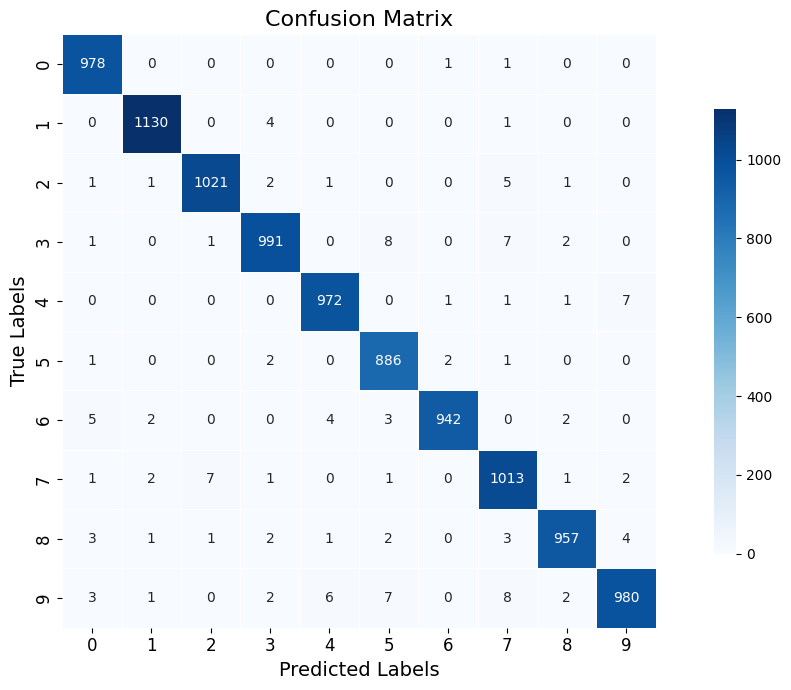

In [50]:
plt.figure(figsize=(12, 7))
sns.heatmap(CF.compute().to('cpu'),
            annot=True, 
            fmt='d', 
            cmap='Blues', 
            linewidths=0.5, 
            square=True, 
            cbar_kws={"shrink": 0.75})

plt.title("Confusion Matrix", fontsize=16)
plt.xlabel("Predicted Labels", fontsize=14)
plt.ylabel("True Labels", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()